# FL
* Fish Lake Small Domain
## Reproject and Create Resampled NetCDFS

Created new env: From *rasterio*, a copy of that to install rioxarray, now *rasterio_copy*


In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
import rioxarray
import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rasterstats

In [2]:
!conda env list

# conda environments:
#
base                     C:\Users\Lumbr\miniconda3
raster                   C:\Users\Lumbr\miniconda3\envs\raster
rasterio                 C:\Users\Lumbr\miniconda3\envs\rasterio
rasterio_copy         *  C:\Users\Lumbr\miniconda3\envs\rasterio_copy
unload                   C:\Users\Lumbr\miniconda3\envs\unload



In [3]:
# labels and cosntants 
# titles
title = 'Fish Lake'

# labels 
dce_label = 'distance to canopy edge (m)'
dah_label = 'diurnal anisotropic heat index'
slope_label = 'slope (degrees)'
aspect_label = 'aspect (degrees)'
snow_label = 'snow depth (m)'

dceclassdict = {1: 'Large Clusters', 2: 'Small Clusters', 3: 'Edges', 4: 'Small Gaps', 5: 'Large Gaps'}

In [4]:
# Full Domain Paths
# tif_snowdepth = rioxarray.open_rasterio("/Users/Lumbr/OneDrive - UW/Documents/ArcGIS/Projects/Data/Output/FL_snowdepth.tif", masked=True)
# tif_dce = rioxarray.open_rasterio("/Users/Lumbr/OneDrive - UW/Documents/ArcGIS/Projects/Data/Output/FL_dce.tif", masked=True)
# tif_dah = rioxarray.open_rasterio("/Users/Lumbr/OneDrive - UW/Documents/ArcGIS/Projects/Data/Output/FL_dah.tif", masked=True)

# Small Domain Paths
tif_snowdepth = rioxarray.open_rasterio("/Users/Lumbr/OneDrive - UW/Documents/ArcGIS/Projects/Data/Output/FL_smalldomain_snowdepth.tif", masked=True)
tif_dce = rioxarray.open_rasterio("/Users/Lumbr/OneDrive - UW/Documents/ArcGIS/Projects/Data/Output/FL_smalldomain_dce.tif", masked=True)
tif_dah = rioxarray.open_rasterio("/Users/Lumbr/OneDrive - UW/Documents/ArcGIS/Projects/Data/Output/FL_smalldomain_dah.tif", masked=True)
tif_dem = rioxarray.open_rasterio("/Users/Lumbr/OneDrive - UW/Documents/ArcGIS/Projects/Data/Output/FL_smalldomain_dtm_snowoff.tif", masked=True)

# Write to an xarray dataset 
# ds = xr.Dataset({"snowdepth":tif_snowdepth,"dce":tif_dce,"dah":tif_dah}) # this doesn't work, we need to add the reproject match

ds = xr.Dataset({"snowdepth":tif_snowdepth,
                 "dce":tif_dce.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "dem":tif_dem.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "dah":tif_dah.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear)})

In [5]:
## I am confused by the crs reproject is working for this dataset and not for CER 
## anyway, adding the note here and commenting it out in case I need it later 
## NAD83(HARN) is Washington State South (ftUS) EPSG:2927

# # have to set the crs if we are going to reproject_match or reproject 
# tif_snowdepth.rio.write_crs('epsg:2927', inplace=True)
# tif_dce.rio.write_crs('epsg:2927', inplace=True)
# tif_dah.rio.write_crs('epsg:2927', inplace=True)

## Reproject to Downsample Dataset (for stats later)
* Resample the dataset before creating any of the other variables 

In [6]:
# resampling from 3 by 3 feet (1 meter) to.. 
#  9 by  9 feet (3 meters) 
# 15 by 15 feet (5 meters) 
# 30 by 30 feet (10 meters)

# ds = ds.rio.reproject(dst_crs=ds.rio.crs, resolution=9, resampling=Resampling.cubic) 
# ds = ds.rio.reproject(dst_crs=ds.rio.crs, resolution=15, resampling=Resampling.cubic) 
ds = ds.rio.reproject(dst_crs=ds.rio.crs, resolution=30, resampling=Resampling.cubic) 

C:\Users\Lumbr\miniconda3\envs\rasterio_copy\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


C:\Users\Lumbr\miniconda3\envs\rasterio_copy\lib\site-packages\matplotlib\colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


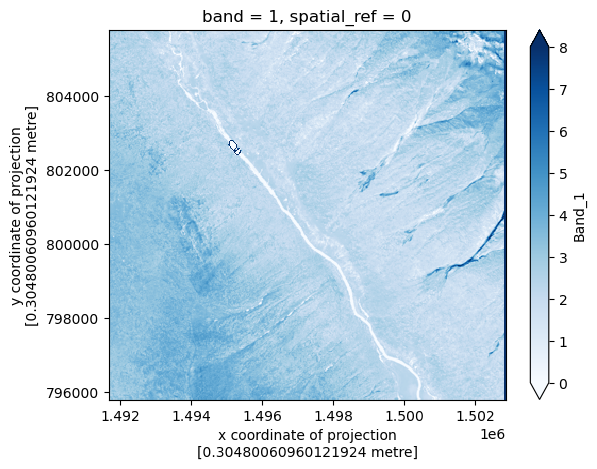

In [7]:
ds.snowdepth.plot(cmap='Blues', vmin=0, vmax=8)

### Now, continue with making classifications

In [8]:
ds['dce'] = ds['dce'].where(~(ds['dce'] > 50), drop=True) # droping any gaps that are bigger than 50
ds['dce'] = ds['dce'].where(~(ds['dce'] < -50), drop=True) # droping any gaps that are smaller than -50

ds['dah'] = ds['dah'].where(~(ds['dah'] > 50), drop=True) # droping any gaps that are bigger than 50
ds['dah'] = ds['dah'].where(~(ds['dah'] < -50), drop=True) # droping any gaps that are smaller than -50

# ds['snowdepth'] = ds['snowdepth'].where(~(ds['snowdepth'] == -9999), drop=True) # dropping the -9999
ds['snowdepth'] = ds['snowdepth'].where(ds['snowdepth'] >= 0, drop=True) # only keeping snow depth >= 0 for now... coming back to this 
ds['snowdepth'] = ds['snowdepth'].where(ds['snowdepth'] < 20, drop=True) # only keeping snow depth < 20 for now... coming back to this 

### Proper reclassification groups

|group|name|DCE range|
|-|-|--:|
|group 1:|Large Gaps|3 <  DCE <=  8|
|group 2:|Small Gaps|1 <  DCE <=  3|
|group 3:|Edges|-1 <= DCE <=  1
|group 4:|Small Clusters|-3 <= DCE <= -1|
|group 5:|Large Clusters|      DCE <  -3|

In [9]:
# fix up dah classification for zero to be with negative values
dah_reclass = ds.dah.copy(deep=True)

dah_reclass = dah_reclass.where(dah_reclass <= 0, 1) # xarray.where cond = False, replace with value
dah_reclass = dah_reclass.where(dah_reclass > 0, -1)

# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds.dce.copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 8), drop=True)                       # droping any gaps that are bigger than 8
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  8)), 500) # group 1: Large Gaps      3 <  DCE <=  8
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                             # group 5: Large Clusters       DCE <= -3

ds['dah_reclass'] = dah_reclass.copy(deep=True)
ds['dce_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['largeclusters'] = ds.dce_reclass.where(ds.dce_reclass == 100)
ds['smallclusters'] = ds.dce_reclass.where(ds.dce_reclass == 200)
ds['canopyedges']   = ds.dce_reclass.where(ds.dce_reclass == 300)
ds['smallgaps']     = ds.dce_reclass.where(ds.dce_reclass == 400)
ds['largegaps']     = ds.dce_reclass.where(ds.dce_reclass == 500)

### make different datasets for groups that are dah > 0 and dah < 0 to do statistics on 

In [10]:
# also need to create groups where each canopy edge group is broken up by DAH positive or negative 

# first, create two new dataframes for one positive and one negative dah
ds_dahpos = ds.where(ds.dah >= 0)
ds_dahneg = ds.where(ds.dah < 0)

# then, classify based on each different dataframe
dce_dahpos_reclass = ds_dahpos.dce.copy(deep=True) 
dce_dahneg_reclass = ds_dahneg.dce.copy(deep=True)                                

dce_dahpos_reclass = dce_dahpos_reclass.where(~(dce_dahpos_reclass > 8), drop=True)                            # droping any gaps that are bigger than 8
dce_dahneg_reclass = dce_dahneg_reclass.where(~(dce_dahneg_reclass > 8), drop=True)                            # droping any gaps that are bigger than 8

dce_dahpos_reclass = dce_dahpos_reclass.where(~(( 3 <  dce_dahpos_reclass) & (dce_dahpos_reclass <=  8)), 500) # group 1: Large Gaps      3 <  DCE <=  8, only on DAH > 0 ds
dce_dahneg_reclass = dce_dahneg_reclass.where(~(( 3 <  dce_dahneg_reclass) & (dce_dahneg_reclass <=  8)), 500) # group 1: Large Gaps      3 <  DCE <=  8, only on DAH < 0 ds

dce_dahpos_reclass = dce_dahpos_reclass.where(~(( 1 <  dce_dahpos_reclass) & (dce_dahpos_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3, only on DAH > 0 ds
dce_dahneg_reclass = dce_dahneg_reclass.where(~(( 1 <  dce_dahneg_reclass) & (dce_dahneg_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3, only on DAH < 0 ds

dce_dahpos_reclass = dce_dahpos_reclass.where(~((-1 <= dce_dahpos_reclass) & (dce_dahpos_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1 , only on DAH > 0 ds
dce_dahneg_reclass = dce_dahneg_reclass.where(~((-1 <= dce_dahneg_reclass) & (dce_dahneg_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1, only on DAH < 0 ds

dce_dahpos_reclass = dce_dahpos_reclass.where(~((-3 <= dce_dahpos_reclass) & (dce_dahpos_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1, only on DAH > 0 ds
dce_dahneg_reclass = dce_dahneg_reclass.where(~((-3 <= dce_dahneg_reclass) & (dce_dahneg_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1, only on DAH < 0 ds

dce_dahpos_reclass = dce_dahpos_reclass.where(~(dce_dahpos_reclass <-3), 100)                                  # group 5: Large Clusters       DCE <= -3, only on DAH > 0 ds 
dce_dahneg_reclass = dce_dahneg_reclass.where(~(dce_dahneg_reclass <-3), 100)                                  # group 5: Large Clusters       DCE <= -3, only on DAH < 0 ds

# add this to our other dataframe so it's a bit easier to work with when needed 
ds['dce_dahpos_reclass'] = dce_dahpos_reclass.copy(deep=True)
ds['dce_dahneg_reclass'] = dce_dahneg_reclass.copy(deep=True)

In [11]:
# We want all the snow depth values.. for each dce group

# Also saving these into the xarray dataframe, then else is nan for each group 
ds['largeclusters_snowdepth'] = ds.snowdepth.where(ds.dce_reclass == 100)
ds['smallclusters_snowdepth'] = ds.snowdepth.where(ds.dce_reclass == 200)
ds['canopyedges_snowdepth']   = ds.snowdepth.where(ds.dce_reclass == 300)
ds['smallgaps_snowdepth']     = ds.snowdepth.where(ds.dce_reclass == 400)
ds['largegaps_snowdepth']     = ds.snowdepth.where(ds.dce_reclass == 500)

# And, we want (from those) where dah is positive or negative 
ds['largeclusters_posdah_snowdepth'] = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass == 100))
ds['largeclusters_negdah_snowdepth'] = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass == 100))

ds['smallclusters_posdah_snowdepth'] = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass == 200))
ds['smallclusters_negdah_snowdepth'] = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass == 200))

ds['canopyedges_posdah_snowdepth']   = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass == 300))
ds['canopyedges_negdah_snowdepth']   = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass == 300))

ds['smallgaps_posdah_snowdepth']     = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass == 400))
ds['smallgaps_negdah_snowdepth']     = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass == 400))

ds['largegaps_posdah_snowdepth']     = ds.snowdepth.where((ds.dah >= 0) & (ds.dce_reclass == 500))
ds['largegaps_negdah_snowdepth']     = ds.snowdepth.where((ds.dah <  0) & (ds.dce_reclass == 500))

## Write the cleaned dataset to a netcdf to open later

In [12]:
# ds.to_netcdf('/Users/Lumbr/OneDrive - UW/Documents/Washington/EasternCascades/Python/Output/fl_smalldomain_create_netcdf_9by9.nc')
# ds.to_netcdf('/Users/Lumbr/OneDrive - UW/Documents/Washington/EasternCascades/Python/Output/fl_smalldomain_create_netcdf_15by15.nc')
ds.to_netcdf('/Users/Lumbr/OneDrive - UW/Documents/Washington/EasternCascades/Python/Output/fl_smalldomain_create_netcdf_30by30.nc')

In [13]:
ds2 = xr.open_dataset('/Users/Lumbr/OneDrive - UW/Documents/Washington/EasternCascades/Python/Output/fl_smalldomain_create_netcdf_30by30.nc')
ds2

<xarray.Dataset>
Dimensions:                         (x: 373, y: 333, band: 1)
Coordinates:
  * x                               (x) float64 1.492e+06 ... 1.503e+06
  * y                               (y) float64 8.058e+05 ... 7.958e+05
  * band                            (band) int32 1
Data variables: (12/29)
    snowdepth                       (band, y, x) float32 ...
    dce                             (band, y, x) float32 ...
    dem                             (band, y, x) float32 ...
    dah                             (band, y, x) float32 ...
    dah_reclass                     (band, y, x) float32 ...
    dce_reclass                     (band, y, x) float32 ...
    ...                              ...
    canopyedges_negdah_snowdepth    (band, y, x) float32 ...
    smallgaps_posdah_snowdepth      (band, y, x) float32 ...
    smallgaps_negdah_snowdepth      (band, y, x) float32 ...
    largegaps_posdah_snowdepth      (band, y, x) float32 ...
    largegaps_negdah_snowdepth      (band, y, x) float32 ...
    spatial_ref                     int32 ...